**Определение стоимости автомобиля** 

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Цель проекта:** Посторить налиучшую модель для определния цены авто.

**Задачи проекта:** 
- Загрузить и изучить данные;
- Произвести предобработку данных
- Подготовить информативные выборки для оубчения моделей;
- Обучить разные модели, изменяя их гиперпараметры и оценивая метрику RMSE;
- Проанализировать время обучения, время предсказания и качество моделей;
- Выбрать наилучшую модель (RMSE < 2500), проверить качество на тестовой выборке.

**Описание данных:**

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**
- Price — цена (евро)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

# Загрузка данных и изучение

In [2]:
try:
    df = pd.read_csv('/datasets/autos.csv', parse_dates = ['DateCrawled', 'LastSeen', 'DateCreated'])
except:
    df = pd.read_csv('autos.csv', parse_dates = ['DateCrawled', 'LastSeen', 'DateCreated'])

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


## Приведение названия столбцов к нижнему змеиному регистру 

In [4]:
df.columns = df.columns.str.lower()
df = df.rename(columns={'datecrawled':'date_crawled', 'vehicletype':'vehicle_type', 'registrationyear':'registration_year', 
                        'registrationmonth':'registration_month', 'fueltype':'fuel_type', 'datecreated':'date_created', 
                        'numberofpictures':'number_of_pictures', 'postalcode':'postal_code', 'lastseen':'last_seen'})
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

## Удаления явных дубликатов

In [6]:
df.duplicated().sum()

4

In [7]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [8]:
df.shape

(354365, 16)

In [9]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [10]:
df.corr()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
price,1.000000,0.026916,0.158872,-0.333207,0.110580,NaN,0.076058
registration_year,0.026916,1.000000,-0.000828,-0.053448,-0.011619,NaN,-0.003459
power,0.158872,-0.000828,1.000000,0.024006,0.043379,NaN,0.021662
kilometer,-0.333207,-0.053448,0.024006,1.000000,0.009575,NaN,-0.007685
registration_month,0.110580,-0.011619,0.043379,0.009575,1.000000,NaN,0.013996
number_of_pictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postal_code,0.076058,-0.003459,0.021662,-0.007685,0.013996,NaN,1.000000


**Вывод:** В исходном датасете более 350 тысяч строк и 16 столбцов. Названия столбцов сразу же приведены к нижнему змеиному регистру, удалены 4 строки с явными дубликатами. В пяти столбцах есть пропуски, которые необходимо заменить. Мультиколлинеарность не наблюдается. В данных есть столбцы, которые никак не влияют на цену автомобиля и от которых нужно избавиться.

# Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.

## Удаление неинформативных признаков

In [11]:
# Первым делом удалим неинформативные столбцы: date_crawled, registration_month, date_created, number_of_pictures, postal_code, last_seen
df = df.drop(['date_crawled', 'registration_month', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'], axis=1)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


## Обработка аномалий в столбцах

Всего в нашем датасете осталось 4 столбца с численными значениями. Рассмотрим детально каждый столбец.

### Price

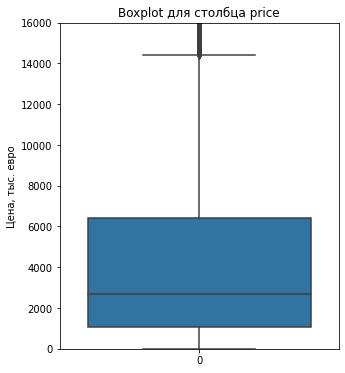

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64


In [12]:
plt.figure(figsize=(5, 6))  
sns.boxplot(data=df['price'], orient='v')
plt.title('Boxplot для столбца price')
plt.ylabel('Цена, тыс. евро')
plt.ylim(0, 16000)
plt.show()
print(df['price'].describe())

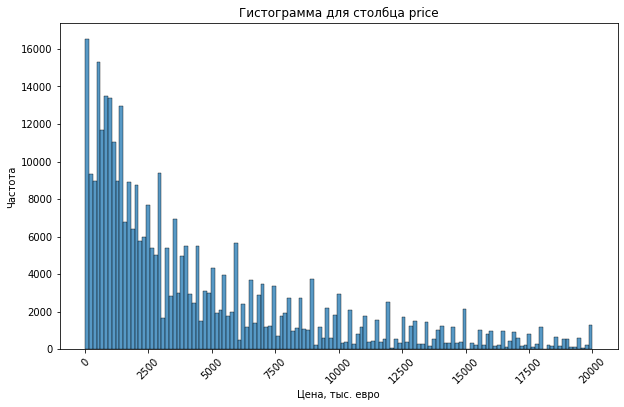

In [13]:
plt.figure(figsize=(10, 6)) 
sns.histplot(data=df['price'])
plt.title('Гистограмма для столбца price')
plt.xlabel('Цена, тыс. евро')
plt.ylabel('Частота')
plt.xticks(rotation=45) 
plt.show()

In [14]:
# boxplot показывает аномальные значения в районе 0 и выше 15000 тыс.евро. Предлагается удалить 5% минимальных, чтобы оставить как можно больше строк для машинного обучения
df['price'].quantile(0.05)

200.0

In [15]:
df = df.query('price > 200')

### Registration year

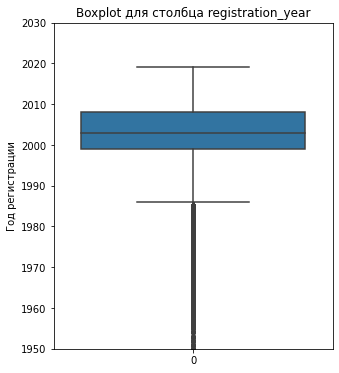

count    334917.000000
mean       2003.977920
std          67.384499
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64


In [16]:
plt.figure(figsize=(5, 6))  
sns.boxplot(data=df['registration_year'], orient='v')
plt.title('Boxplot для столбца registration_year')
plt.ylabel('Год регистрации')
plt.ylim(1950, 2030)
plt.show()
print(df['registration_year'].describe())

In [17]:
# оставим все машины с регистрацией после 1950 года и до 2017 года.
df = df.query('registration_year > 1950 and registration_year < 2017')

### Model

In [18]:
df['model'].value_counts()

golf                  26118
other                 22562
3er                   18463
polo                  11357
corsa                 10743
                      ...  
elefantino                4
rangerover                3
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: model, Length: 250, dtype: int64

In [19]:
df['model'].nunique()

250

In [20]:
# В данном случае самым логичным решением выглядит создание заглушки для пропусков ввиду невозможности корректной замены
df['model'].fillna('unknown', inplace=True)

### Power

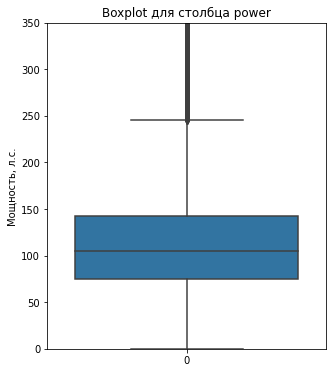

count    321197.000000
mean        113.414976
std         183.962339
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


In [21]:
plt.figure(figsize=(5, 6))  
sns.boxplot(data=df['power'], orient='v')
plt.title('Boxplot для столбца power')
plt.ylabel('Мощность, л.с.')
plt.ylim(0, 350)
plt.show()
print(df['power'].describe())

In [22]:
df.groupby('power').mean()

,price,registration_year,kilometer
power,,,
0,2626.039621,2000.953144,129938.640974
1,1799.631579,1999.526316,94473.684211
2,4323.333333,2004.777778,87222.222222
3,2731.000000,1998.875000,34375.000000
4,3041.500000,2001.200000,45166.666667
...,...,...,...
17932,3250.000000,2001.000000,150000.000000
19208,2100.000000,2001.000000,150000.000000
19211,9999.000000,2006.000000,125000.000000


In [23]:
print(df['power'].describe())

count    321197.000000
mean        113.414976
std         183.962339
min           0.000000
25%          75.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


<AxesSubplot:ylabel='Frequency'>

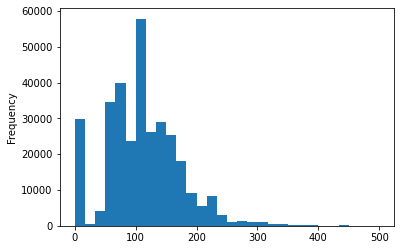

In [24]:
df['power'].plot(kind='hist', bins=30, range=(0, 500))

In [25]:
df.loc[(df['power'] > 1000) | (df['power'] <= 10), 'power'] = None
df['power'] = df['power'].fillna(df.groupby('model')['power'].transform('median'))
df['power'] = df['power'].fillna(df['power'].median())

In [26]:
print(df['power'].describe())

count    321197.000000
mean        120.374062
std          53.353417
min          11.000000
25%          80.000000
50%         110.000000
75%         147.000000
max        1000.000000
Name: power, dtype: float64


### Kilometer

In [27]:
df['kilometer'].describe()

count    321197.000000
mean     128310.195923
std       37152.575473
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

In [28]:
df['kilometer'].value_counts()

150000    214303
125000     33871
100000     13716
90000      10914
80000       9522
70000       8206
60000       7166
50000       5943
40000       4738
30000       4160
5000        4063
20000       3579
10000       1016
Name: kilometer, dtype: int64

В столбце с пробегом отклонений не наблюдается

## Замена пропусков

In [29]:
df.isna().sum()

price                    0
vehicle_type         17258
registration_year        0
gearbox              13557
power                    0
model                    0
kilometer                0
fuel_type            21554
brand                    0
repaired             55666
dtype: int64

### Gearbox

In [30]:
df['gearbox'].value_counts()

manual    245122
auto       62518
Name: gearbox, dtype: int64

In [31]:
# Заменим все пропущенные значения на наиболее популуярные
df['gearbox'].fillna('manual', inplace=True)

### Vehicle type

In [32]:
df['vehicle_type'].value_counts()

sedan          88245
small          74790
wagon          62907
bus            28180
convertible    19751
coupe          15363
suv            11736
other           2967
Name: vehicle_type, dtype: int64

In [33]:
# В данном случае самым логичным решением выглядит создание заглушки для пропусков ввиду невозможности корректной замены
df['vehicle_type'].fillna('unknown', inplace=True)

### Model

In [34]:
df['model'].value_counts()

golf                  26118
other                 22562
3er                   18463
unknown               14479
polo                  11357
                      ...  
elefantino                4
rangerover                3
serie_3                   3
range_rover_evoque        2
serie_1                   1
Name: model, Length: 251, dtype: int64

In [35]:
df['model'].nunique()

251

In [36]:
# В данном случае самым логичным решением выглядит создание заглушки для пропусков ввиду невозможности корректной замены
df['model'].fillna('unknown', inplace=True)

### Repaired

In [37]:
df['repaired'].value_counts()

no     235274
yes     30257
Name: repaired, dtype: int64

In [38]:
# Заменим пропущенные значения на Yes, поскольку скорее всего владельцы авто не указывают информацию о ремонте, чтобы завысить цену.
df['repaired'].fillna('yes', inplace=True)

### Fuel type

In [39]:
df['fuel_type'].value_counts()

petrol      199214
gasoline     94473
lpg           4990
cng            527
hybrid         218
other          137
electric        84
Name: fuel_type, dtype: int64

In [40]:
# В данном случае самым логичным решением выглядит создание заглушки для пропусков ввиду невозможности корректной замены
df['fuel_type'].fillna('unknown', inplace=True)

In [41]:
df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

In [42]:
# Поскольку petrol и gasoline означают одно и то же, в зависимости от страны использования, запишем все в petrol
df['fuel_type'] = df['fuel_type'].replace({'gasoline':'petrol'})
df['fuel_type'].value_counts()

petrol      293687
unknown      21554
lpg           4990
cng            527
hybrid         218
other          137
electric        84
Name: fuel_type, dtype: int64

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 321197 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              321197 non-null  int64  
 1   vehicle_type       321197 non-null  object 
 2   registration_year  321197 non-null  int64  
 3   gearbox            321197 non-null  object 
 4   power              321197 non-null  float64
 5   model              321197 non-null  object 
 6   kilometer          321197 non-null  int64  
 7   fuel_type          321197 non-null  object 
 8   brand              321197 non-null  object 
 9   repaired           321197 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 35.0+ MB


In [44]:
df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

**Вывод:** В ходе предобработки данных удалены неинформативные признаки, обработаны аномальные значения и заменены пропуски. Удалено более 50 тысяч строк. 

# Подготовьте выборки для обучения моделей.

## Выделение признаков и целевого признака

In [45]:
df = df.reset_index(drop=True)

In [46]:
features = df.drop(['price'], axis=1)
target = df['price']

Для машинного обучения необходимо преобразовать категориальные признаки

## Подготовка признаков признаков

### OneHotEncoder

In [47]:
# преобразование категориальных признаков в численные и обход дамми-ловушек
features_ohe = pd.get_dummies(features, drop_first=True)
features_ohe

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_yes
0,1993,101.0,150000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,1
1,2011,190.0,125000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2004,163.0,125000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,2001,75.0,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2008,69.0,90000,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321192,2000,125.0,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
321193,2005,109.0,20000,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
321194,2000,101.0,125000,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
321195,1996,102.0,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [48]:
# разделим данные на тестовые и рабочие
features_train, features_test, target_train, target_test = train_test_split(features_ohe, target, test_size = 0.2, random_state = 12345)

In [49]:
# разделим рабочие данные на обучающие и валидационные
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_train, target_train, test_size = 0.25, random_state = 12345)

In [50]:
features_test.shape, features_valid_ohe.shape, features_train_ohe.shape

((64240, 308), (64240, 308), (192717, 308))

### OrdinalEncoder для randomforest

In [51]:
# разделим данные на тестовые и рабочие
features_train_ordinal, features_test_ordinal, target_train_ordinal, target_test_ordinal = train_test_split(features, target, test_size = 0.2, random_state = 12345)

In [52]:
# разделим рабочие данные на обучающие и валидационные
features_train_ord, features_valid_ord, target_train_ord, target_valid_ord = train_test_split(features_train_ordinal, target_train_ordinal, test_size = 0.25, random_state = 12345)

In [53]:
features_train_ord.shape, features_valid_ord.shape, features_test_ordinal.shape

((192717, 9), (64240, 9), (64240, 9))

In [54]:
# для деревянных моделей преобразуем данные с помощью Ordinal Encoding
# Выбор категориальных столбцов из вашего обучающего набора данных

categorical_columns = features_train_ord[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']]

# Создание экземпляра класса OrdinalEncoder с параметром handle_unknown='ignore'
encoder = OrdinalEncoder(handle_unknown='ignore')

# Преобразование категориальных столбцов в числовые значения
features_categorical_encoded = encoder.fit_transform(categorical_columns)

# Создание нового DataFrame с преобразованными признаками
features_categorical_encoded_df = pd.DataFrame(features_categorical_encoded, columns=categorical_columns.columns)

features_categorical_encoded_df.index = categorical_columns.index
# Объединение порядково закодированных категориальных признаков с числовыми признаками


features_train_ord = pd.concat([features_train_ord[['registration_year', 'power', 'kilometer']], features_categorical_encoded_df], axis=1)

# Вывод результирующего DataFrame
features_train_ord

,registration_year,power,kilometer,vehicle_type,gearbox,model,fuel_type,brand,repaired
2319,1993,101.0,150000,4.0,1.0,20.0,5.0,1.0,1.0
279760,2010,200.0,125000,6.0,0.0,209.0,5.0,15.0,0.0
126081,2005,120.0,150000,7.0,1.0,136.0,5.0,27.0,1.0
12573,2000,85.0,150000,0.0,1.0,224.0,5.0,38.0,1.0
307396,2007,140.0,150000,4.0,1.0,170.0,5.0,38.0,1.0
...,...,...,...,...,...,...,...,...,...
69698,1996,102.0,150000,2.0,1.0,11.0,5.0,2.0,1.0
283187,1990,129.0,150000,4.0,1.0,15.0,5.0,2.0,0.0
63176,2007,105.0,90000,4.0,1.0,235.0,5.0,24.0,0.0
200270,2012,170.0,40000,8.0,0.0,163.0,5.0,31.0,0.0


In [55]:
# Кодирование признаков в валидационной выборке
categorical_columns_val = features_valid_ord[['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']]


features_categorical_encoded_val = encoder.transform(categorical_columns_val)


features_categorical_encoded_df_val = pd.DataFrame(features_categorical_encoded_val, columns=categorical_columns_val.columns)

features_categorical_encoded_df_val.index = categorical_columns_val.index


features_valid_ord = pd.concat([features_valid_ord[['registration_year', 'power', 'kilometer']], features_categorical_encoded_df_val], axis=1)

In [56]:
features_train_ord.shape, features_valid_ord.shape, features_test_ordinal.shape

((192717, 9), (64240, 9), (64240, 9))

**Вывод:** Произвели разделение данных на признаки и целевой признак. Закодировали катеориальные признаки с помощью OneHotEncoding и OrdinalEncoding. Выделили тестовую выборку.

# Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.

## Linear Regression

In [57]:
model_lr = LinearRegression()

In [58]:
%%time
model_lr.fit(features_train_ohe, target_train_ohe)

CPU times: user 14.2 s, sys: 7.17 s, total: 21.3 s
Wall time: 21.4 s


LinearRegression()

In [59]:
%%time
predictions_lr = model_lr.predict(features_valid_ohe)

CPU times: user 81.8 ms, sys: 97.9 ms, total: 180 ms
Wall time: 194 ms


In [60]:
rmse_lr = mean_squared_error(target_valid_ohe, predictions_lr)**0.5
rmse_lr

2687.731526058365

## Random Forest

In [61]:
model_rf = RandomForestRegressor(random_state=12345)

In [62]:
%%time
model_rf.fit(features_train_ord, target_train_ord)

CPU times: user 43.7 s, sys: 713 ms, total: 44.4 s
Wall time: 44.5 s


RandomForestRegressor(random_state=12345)

In [63]:
%%time
predictions_rf = model_rf.predict(features_valid_ord)

CPU times: user 2.49 s, sys: 354 µs, total: 2.49 s
Wall time: 2.51 s


In [64]:
rmse_rf = mean_squared_error(target_valid_ord, predictions_rf)**0.5
rmse_rf

1675.7558779970482

### Подбор гиперпараметров

In [65]:
params_grid = {
    'n_estimators' : [10, 50, 100],
    'max_depth' : [2, 5, 10, 15]
}

In [66]:
GS_rf = GridSearchCV(estimator = model_rf,
                     param_grid = params_grid,
                     scoring = 'neg_root_mean_squared_error',
                     cv=5, verbose=2)   

In [67]:
%%time
GS_rf.fit(features_train_ord, target_train_ord)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.5s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.5s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.5s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.5s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.6s
[CV] END .......................max_depth=2, n_estimators=50; total time=   2.6s
[CV] END .......................max_depth=2, n_estimators=50; total time=   2.7s
[CV] END .......................max_depth=2, n_estimators=50; total time=   2.7s
[CV] END .......................max_depth=2, n_estimators=50; total time=   2.7s
[CV] END .......................max_depth=2, n_estimators=50; total time=   2.5s
[CV] END ......................max_depth=2, n_estimators=100; total time=   5.0s
[CV] END ......................max_depth=2, n_es

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [2, 5, 10, 15],
                         'n_estimators': [10, 50, 100]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [68]:
GS_rf.best_params_

{'max_depth': 15, 'n_estimators': 100}

In [69]:
-GS_rf.best_score_

1694.132651073572

In [70]:
results_rf = GS_rf.cv_results_
best_fit_time_rf = results_rf['mean_fit_time'][GS_rf.best_index_]
best_fit_time_rf

25.870518922805786

In [71]:
%%time
predictions_GS_rf = GS_rf.predict(features_valid_ord)

CPU times: user 1.16 s, sys: 4 ms, total: 1.16 s
Wall time: 1.16 s


In [72]:
rmse_rf = mean_squared_error(predictions_GS_rf, target_valid_ord)**0.5
rmse_rf

1688.233941631238

In [73]:
GS_rf.best_estimator_.feature_importances_

array([0.53012839, 0.27889951, 0.06986267, 0.03199342, 0.00558738,
       0.03063373, 0.00372188, 0.0366845 , 0.01248852])

In [74]:
feature_names = features.columns
feature_names

Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

<BarContainer object of 9 artists>

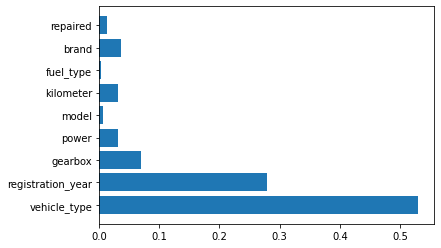

In [75]:
plt.barh(feature_names, GS_rf.best_estimator_.feature_importances_)

## LightGBM 

In [76]:
train_data_lgb = lgb.Dataset(features_train_ohe, target_train_ohe)

In [77]:
params = {
    'objective': 'regression',  # Целевая функция: регрессия
    'metric': 'rmse',           # Метрика для оценки качества модели: среднеквадратичная ошибка
    'num_leaves': 31,           # Максимальное количество листьев в дереве
    'learning_rate': 0.05,      # Скорость обучения
    'verbose': -1               # Уровень детализации вывода
}

In [78]:
%%time
num_round = 100
model_lgb = lgb.train(params, train_data_lgb, num_round)

CPU times: user 6min 22s, sys: 4.23 s, total: 6min 26s
Wall time: 6min 30s


In [79]:
%%time
predictions_lgb = model_lgb.predict(features_valid_ohe)

CPU times: user 732 ms, sys: 103 ms, total: 835 ms
Wall time: 822 ms


In [80]:
rmse_lgb = mean_squared_error(target_valid_ohe, predictions_lgb)**0.5
rmse_lgb

1808.0226393562514

### Подбор гиперпараметров

In [81]:
params_grid_lgb = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 150, 200]
}

In [82]:
model_lgb = lgb.LGBMRegressor()
GS_lgb = GridSearchCV(estimator = model_lgb,
                     param_grid = params_grid_lgb,
                     scoring = 'neg_root_mean_squared_error',
                     cv=5, verbose=-1)   

In [83]:
%%time
GS_lgb.fit(features_train_ohe, target_train_ohe)

CPU times: user 22min 55s, sys: 33.6 s, total: 23min 28s
Wall time: 23min 41s


GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.05, 0.1],
                         'n_estimators': [100, 150, 200],
                         'num_leaves': [31, 50, 100]},
             scoring='neg_root_mean_squared_error', verbose=-1)

In [84]:
GS_lgb.best_params_

{'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 100}

In [85]:
-GS_lgb.best_score_

1626.951800058315

In [86]:
results_lgb = GS_lgb.cv_results_
best_fit_time_lgb = results_lgb['mean_fit_time'][GS_lgb.best_index_]
best_fit_time_lgb

16.716815614700316

In [87]:
%%time
predictions_GS_lgb = GS_lgb.predict(features_valid_ohe)

CPU times: user 1.49 s, sys: 107 ms, total: 1.6 s
Wall time: 1.58 s


In [88]:
rmse_lgb = mean_squared_error(target_valid_ohe, predictions_GS_lgb)**0.5
rmse_lgb

1616.4529352330098

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

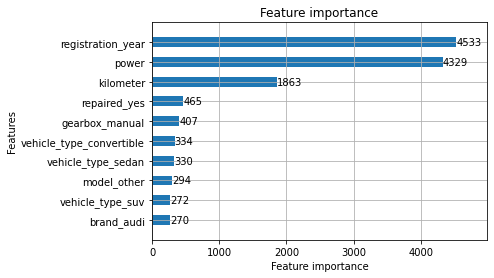

In [89]:
lgb.plot_importance(GS_lgb.best_estimator_, max_num_features=10, height=.5)

## Catboost

In [90]:
model_cat = CatBoostRegressor()

In [91]:
%%time
model_cat.fit(features_train_ohe, target_train_ohe)

Learning rate set to 0.094015
0:	learn: 4272.1417262	total: 82.3ms	remaining: 1m 22s
1:	learn: 4029.6690905	total: 108ms	remaining: 54s
2:	learn: 3808.0763818	total: 134ms	remaining: 44.6s
3:	learn: 3615.1255533	total: 160ms	remaining: 39.7s
4:	learn: 3448.9412683	total: 185ms	remaining: 36.9s
5:	learn: 3299.9644642	total: 211ms	remaining: 35s
6:	learn: 3167.4481833	total: 237ms	remaining: 33.7s
7:	learn: 3050.6469385	total: 262ms	remaining: 32.5s
8:	learn: 2940.3653590	total: 287ms	remaining: 31.6s
9:	learn: 2841.5726000	total: 314ms	remaining: 31.1s
10:	learn: 2759.1098911	total: 340ms	remaining: 30.6s
11:	learn: 2685.2786926	total: 367ms	remaining: 30.2s
12:	learn: 2620.3761070	total: 392ms	remaining: 29.8s
13:	learn: 2564.3667397	total: 418ms	remaining: 29.4s
14:	learn: 2507.0387542	total: 444ms	remaining: 29.2s
15:	learn: 2460.0885488	total: 469ms	remaining: 28.9s
16:	learn: 2418.4695741	total: 495ms	remaining: 28.6s
17:	learn: 2380.3754599	total: 521ms	remaining: 28.4s
18:	learn:

In [92]:
%%time
predictions_cat = model_cat.predict(features_valid_ohe)

CPU times: user 116 ms, sys: 7.86 ms, total: 124 ms
Wall time: 123 ms


In [93]:
rmse_cat = mean_squared_error(target_valid_ohe, predictions_cat)**0.5
rmse_cat

1650.123385562304

### Подбор гиперпараметров

In [94]:
model_cat = CatBoostRegressor()

In [95]:
params_grid_cat = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'iterations': [100, 150, 200]
}

In [96]:
GS_cat = GridSearchCV(estimator=model_cat, param_grid=params_grid_cat, cv=5, scoring='neg_root_mean_squared_error', verbose=2)

In [97]:
%%time
GS_cat.fit(features_train_ohe, target_train_ohe)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0:	learn: 4522.0759900	total: 21.8ms	remaining: 2.16s
1:	learn: 4495.1440498	total: 38.7ms	remaining: 1.9s
2:	learn: 4469.2108758	total: 56.2ms	remaining: 1.82s
3:	learn: 4443.4213834	total: 73ms	remaining: 1.75s
4:	learn: 4417.4268215	total: 89.3ms	remaining: 1.7s
5:	learn: 4392.5489951	total: 106ms	remaining: 1.66s
6:	learn: 4367.8016254	total: 123ms	remaining: 1.63s
7:	learn: 4343.1909854	total: 140ms	remaining: 1.61s
8:	learn: 4318.6707440	total: 157ms	remaining: 1.58s
9:	learn: 4294.2373194	total: 174ms	remaining: 1.57s
10:	learn: 4270.4145762	total: 191ms	remaining: 1.55s
11:	learn: 4247.4890278	total: 208ms	remaining: 1.52s
12:	learn: 4224.2585271	total: 224ms	remaining: 1.5s
13:	learn: 4201.1817988	total: 242ms	remaining: 1.49s
14:	learn: 4178.7012107	total: 259ms	remaining: 1.47s
15:	learn: 4156.5260841	total: 275ms	remaining: 1.44s
16:	learn: 4134.3990098	total: 293ms	remaining: 1.43s
17:	learn: 4112.8022931	total:

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7fee2da25b80>,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [100, 150, 200],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [98]:
GS_cat.best_params_

{'depth': 10, 'iterations': 200, 'learning_rate': 0.1}

In [99]:
-GS_cat.best_score_

1696.9082945170885

In [100]:
results_cat = GS_cat.cv_results_
best_fit_time_cat = results_cat['mean_fit_time'][GS_cat.best_index_]
best_fit_time_cat

10.70753746032715

In [101]:
%%time
predictions_GS_cat = GS_cat.predict(features_valid_ohe)

CPU times: user 71.8 ms, sys: 92 µs, total: 71.9 ms
Wall time: 71.2 ms


In [102]:
rmse_cat = mean_squared_error(predictions_GS_cat, target_valid_ohe)**0.5
rmse_cat

1692.652492483265

# Проанализируйте время обучения, время предсказания и качество моделей.

In [112]:
models_info = [['LinearRegression', rmse_lr, '21.40000', '194 ms'],
            ['RandomForestRegression', rmse_rf, best_fit_time_rf, '1160 ms'],
            ['LightGBM', rmse_lgb, best_fit_time_lgb, '1580 ms'],
            ['CatBoost', rmse_cat, best_fit_time_cat, '71 ms']]

In [113]:
pd.DataFrame(models_info, columns=["Model","RMSE", "fit_time, sec", "predict_time"])

,Model,RMSE,"fit_time, sec",predict_time
0,LinearRegression,2687.731526,21.4,194 ms
1,RandomForestRegression,1688.233942,25.870519,1160 ms
2,LightGBM,1616.452935,16.716816,1580 ms
3,CatBoost,1692.652492,10.707537,71 ms


**Вывод:** Наилучшее значение метрики RMSE и скорости обучения показала модель LightGBM, она является самой точной и быстрой.

# Проверка качества модели на тестовой выборке.

Для проверки на тестовой выборке возьмем суммарную выборку из обучающей и валидационной для улучшения метрики RMSE.

In [105]:
features_train.shape

(256957, 308)

In [106]:
features_train.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_unknown,...,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_yes
286906,1992,102.0,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
47349,2000,320.0,150000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8637,2016,163.0,150000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
254882,2006,102.0,90000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
251158,2002,116.0,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
model_lgb = lgb.LGBMRegressor(learning_rate=0.1, n_estimators=200, num_leaves=100)

In [108]:
%%time
model_lgb.fit(features_train, target_train)

CPU times: user 24.9 s, sys: 484 ms, total: 25.4 s
Wall time: 25.5 s


LGBMRegressor(n_estimators=200, num_leaves=100)

In [109]:
%%time
predictions_test = model_lgb.predict(features_test)

CPU times: user 1.48 s, sys: 80.5 ms, total: 1.56 s
Wall time: 1.6 s


In [110]:
rmse_test = mean_squared_error(predictions_test, target_test)**0.5
rmse_test

1600.090859437419

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

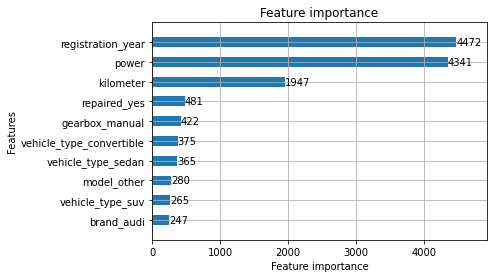

In [111]:
lgb.plot_importance(model_lgb, max_num_features=10, height=.5)

**Вывод:** При проверке модели на тестовой выборке метрика качества RMSE составила 1494 тыс.евро, что меньше порогового значения в 2500 тыс.евро. 

# Общий вывод

В ходе работы на проектом выполнены следующие мероприятия:
- Загружены и проанализированы данные по автомобилям, заполнены пропущенные значения и обработаны аномалии в столбцах. Также удалены неинформативные столбцы.
- Подготовлены выборки для обучения и тестирования моделей. Категориальные признаки закодированы в числовые.
- Обучены 4 разные модели (LinearRegression, RandomForest, LightGBM и CatBoost), подобраны оптимальные гиперпараметры. 
- Выбрана наилучшая модель по точности предсказания цены авто, скорости обучения и скорости предсказания. Ей оказалась модель LightGBM.
- При проверке качества модели на тестовой выборке метрика RMSE составила 1600 евро. Переобучения не наблюдается.